In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 制作数据集

# 设定下载参数
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(0.1307, 0.3081)
])

# 下载训练集与测试集
train_Data = datasets.MNIST(
    root = 'D:\Jupyter\深度学习(5)：卷积神经网络（CNN）', 
    train = True, 
    download = True, 
    transform = transform
)
test_Data = datasets.MNIST(
    root = 'D:\Jupyter\深度学习(5)：卷积神经网络（CNN）', 
    train = False, 
    download = True, 
    transform = transform
)

In [4]:
# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=256)
test_loader  = DataLoader(test_Data, shuffle=False, batch_size=256)

In [5]:
# 构建神经网络，在PyTorch中构建神经网络需要自定义继承torch.nn.Module类，并重写forward（）方法
# torch.nn.Module是torch.nn.Linear、torch.nn.ReLU等卷积，池化运算或神经网络的类的父类

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.net = nn.Sequential(
            
#卷积层Conv2d需传入参数输入通道、输出通道（采样器个数）、采样器大小、移动步长、填充步幅、
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Tanh(), #C1卷积层
#平均池化层
            nn.AvgPool2d(kernel_size=2, stride=2),                # S2平均汇聚
            nn.Conv2d(6, 16, kernel_size=5), nn.Tanh(),           # C3卷积层
            nn.AvgPool2d(kernel_size=2, stride=2),                # S4平均汇聚
            nn.Conv2d(16, 120, kernel_size=5), nn.Tanh(),         # C5卷积层
            nn.Flatten(),                                         # 把图像铺平成一维
            nn.Linear(120, 84), nn.Tanh(),                        # F5全连接层
            nn.Linear(84, 10)                                     # F6全连接层
        )

    def forward(self, x):
        y = self.net(x)
        return y

In [6]:
# 查看网络结构
# 表示创建一个大小为(1, 1, 28, 28)的四维张量，该张量的值由在区间[0, 1)内的均匀分布随机生成，
# 前两个维度(1, 1)表示该张量是一个1x1的单通道张量，后两个维度(28, 28)表示每个图像的高和宽均为28个像素
# 通常在深度学习中，图像数据被表示为四维张量，第一个维度表示批次大小，第二个维度表示通道数，
# 后面两个维度表示图像的高和宽
X = torch.rand(size= (1, 1, 28, 28))
for layer in CNN().net:
    X = layer(X)
    print( layer.__class__.__name__, 'output shape: \t', X.shape )

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Tanh output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Tanh output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Conv2d output shape: 	 torch.Size([1, 120, 1, 1])
Tanh output shape: 	 torch.Size([1, 120, 1, 1])
Flatten output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Tanh output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [7]:
# 创建子类的实例，并搬到GPU上
model = CNN()#.to('cuda:0')

In [8]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss()    # 自带softmax激活函数

In [9]:
# 优化算法的选择
learning_rate = 0.9    # 设置学习率
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, )

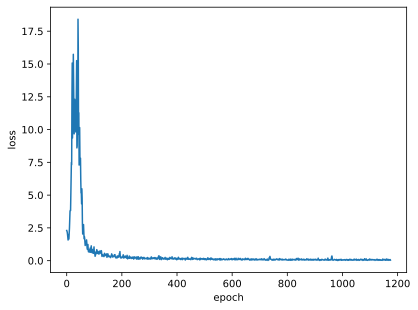

In [10]:
# 训练网络
epochs = 5
losses = []        # 记录损失函数变化的列表

for epoch in range(epochs):
    for (x, y) in train_loader:                  # 获取小批次的x与y
#         x, y = x.to('cuda:0'), y.to('cuda:0')    # 把小批次搬到GPU上
        Pred = model(x)                          # 一次前向传播（小批量）
        loss = loss_fn(Pred, y)                  # 计算损失函数
        losses.append(loss.item())               # 记录损失函数的变化
        optimizer.zero_grad()                    # 清理上一轮滞留的梯度
        loss.backward()                          # 一次反向传播
        optimizer.step()                         # 优化内部参数

Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.ylabel('loss')
plt.xlabel('len(losses)')
plt.show()

In [11]:
# 测试网络
correct = 0
total = 0

with torch.no_grad():                                   # 该局部关闭梯度计算功能
    for (x, y) in test_loader:                          # 获取小批次的x与y
#         x, y = x.to('cuda:0'), y.to('cuda:0')           # 把小批次搬到GPU上
        Pred = model(x)                                 # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0) 
        
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 97.72000122070312 %
